In [7]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
# representation of model layers
from keras.utils.vis_utils import plot_model

In [8]:
NSL_KDD_train_path="/kaggle/input/nslkdd/KDDTrain+.txt"
NSL_KDD_test_path="/kaggle/input/nslkdd/KDDTest+.txt"
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]
  
df_train=pd.read_csv(NSL_KDD_train_path, sep=",", names=datacols)
df_test=pd.read_csv(NSL_KDD_test_path, sep=",", names=datacols)
print(df_train.info())
print("-------------------------------------------")
print(df_train.head(5))
print("-------------------------------------------")
print(df_train.dtypes[df_train.dtypes == object])
print("-------------------------------------------")
print(df_train['attack'].value_counts())
print("-------------------------------------------")
print(df_train.isnull().sum())

print("###########################################") 

print(df_test.info())
print("-------------------------------------------")
print(df_test.head(5))
print("-------------------------------------------")
print(df_test.dtypes[df_test.dtypes == object])
print("-------------------------------------------")
print(df_test['attack'].value_counts())
print(df_test.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [9]:
#drop unwanted column lasted flag 
df_train = df_train.iloc[:,:-1]
df_test = df_test.iloc[:,:-1]
# for i in ['protocol_type',"service","flag"]:
#   X_train[i] = X_train[i].astype('category').cat.codes
#   X_test[i] = X_test[i].astype('category').cat.codes

In [10]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
train_data = df_train
test_data = df_test
multi_data = train_data.copy()
multi_label = pd.DataFrame(multi_data.attack)

In [11]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

numeric_col = multi_data.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)

In [12]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['intrusion'] = enc_label
#y_mul = multi_data['intrusion']
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,intrusion
0,-0.110249,tcp,ftp_data,SF,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,normal,11
1,-0.110249,udp,other,SF,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,normal,11
2,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,neptune,9
3,-0.110249,tcp,http,SF,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,normal,11
4,-0.110249,tcp,http,SF,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,normal,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.938287,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,neptune,9
125969,-0.107178,udp,private,SF,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,...,0.977304,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,normal,11
125970,-0.110249,tcp,smtp,SF,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.893738,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387,normal,11
125971,-0.110249,tcp,klogin,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.094207,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,neptune,9


In [13]:
multi_data.drop(labels= ['attack'], axis=1, inplace=True)
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion
0,-0.110249,tcp,ftp_data,SF,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,11
1,-0.110249,udp,other,SF,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,11
2,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,9
3,-0.110249,tcp,http,SF,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,11
4,-0.110249,tcp,http,SF,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.818890,-0.938287,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,9
125969,-0.107178,udp,private,SF,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,...,1.159389,0.977304,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,11
125970,-0.110249,tcp,smtp,SF,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.773724,-0.893738,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387,11
125971,-0.110249,tcp,klogin,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.972455,-1.094207,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,9


In [14]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")  
multi_data

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,-0.110249,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,0,0,0,0,1,0
1,-0.110249,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,0,0,0,0,1,0
2,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,1,0,0,0,0,0
3,-0.110249,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,0,0,0,0,0,0,0,0,1,0
4,-0.110249,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,1,0,0,0,0,0
125969,-0.107178,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,0,0,0,0,1,0
125970,-0.110249,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,0,0,0,0,0,0,0,0,1,0
125971,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,1,0,0,0,0,0


In [15]:
y_train_multi= multi_data[['intrusion']]
X_train_multi= multi_data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_train_multi.shape,'\ny_train has shape:',y_train_multi.shape)

X_train has shape: (125973, 122) 
y_train has shape: (125973, 1)


In [16]:
from sklearn.preprocessing import LabelBinarizer

y_train_multi = LabelBinarizer().fit_transform(y_train_multi)
y_train_multi

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
X_train_multi=np.array(X_train_multi)
y_train_multi=np.array(y_train_multi)

In [18]:
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_train_multi,y_train_multi, test_size=0.20, random_state=42)

In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(100778, 122, 1)

In [20]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(25195, 122, 1)

In [21]:
# model = Sequential() # initializing model
# # input layer and first layer with 50 neurons
# model.add(Conv1D(32, 3, padding="same",input_shape = (X_train.shape[1], 1), activation='relu'))
# model.add(MaxPool1D(pool_size=(4)))  
# model.add(Dropout(0.2))
# model.add(Conv1D(32, 3, padding="same", activation='relu'))
# model.add(MaxPool1D(pool_size=(4)))  
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(units=50))
# # output layer with softmax activation
# model.add(Dense(units=23,activation='softmax'))

In [24]:
from keras.layers import SimpleRNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding='same', input_shape = (X_train.shape[1], 1)))
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='same'))
model.add(SimpleRNN(32, activation = 'relu', return_sequences=True))
model.add(SimpleRNN(16, return_sequences=True))  # returns a sequence of vectors of dimension 16
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(units=23,activation='softmax'))

In [25]:
# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# summary of model layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 122, 64)           384       
                                                                 
 conv1d_5 (Conv1D)           (None, 122, 32)           10272     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 122, 32)           2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 122, 16)           784       
                                                                 
 flatten_1 (Flatten)         (None, 1952)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               249984    
                                                                 
 dense_3 (Dense)             (None, 64)               

In [26]:
# training the model on training dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=256,validation_split=0.2)

Epoch 1/50
315/315 [==============================] - 45s 133ms/step - loss: 0.1047 - accuracy: 0.9710 - val_loss: 0.0327 - val_accuracy: 0.9899
Epoch 2/50
315/315 [==============================] - 43s 135ms/step - loss: 0.0290 - accuracy: 0.9912 - val_loss: 0.0278 - val_accuracy: 0.9905
Epoch 3/50
315/315 [==============================] - 43s 136ms/step - loss: 0.0235 - accuracy: 0.9928 - val_loss: 0.0219 - val_accuracy: 0.9938
Epoch 4/50
315/315 [==============================] - 42s 133ms/step - loss: 0.0206 - accuracy: 0.9936 - val_loss: 0.0211 - val_accuracy: 0.9936
Epoch 5/50
315/315 [==============================] - 41s 131ms/step - loss: 0.0193 - accuracy: 0.9938 - val_loss: 0.0224 - val_accuracy: 0.9927
Epoch 6/50
315/315 [==============================] - 42s 133ms/step - loss: 0.0170 - accuracy: 0.9947 - val_loss: 0.0204 - val_accuracy: 0.9937
Epoch 7/50
315/315 [==============================] - 42s 133ms/step - loss: 0.0162 - accuracy: 0.9948 - val_loss: 0.0221 - val_ac

In [35]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

788/788 [==============================] - 15s 19ms/step - loss: 0.0227 - accuracy: 0.9949
Test results - Loss: 0.02274732105433941 - Accuracy: 99.49195981025696%


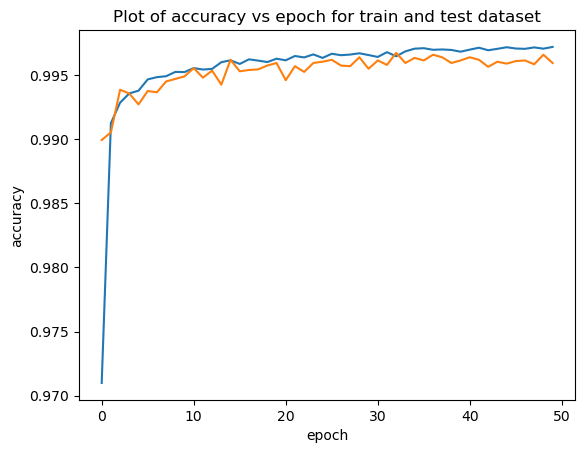

In [36]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

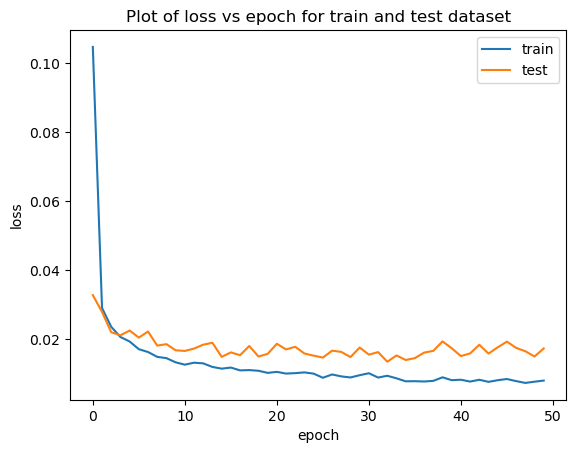

In [37]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [38]:
predict = model.predict(X_test)

788/788 [==============================] - 15s 19ms/step


In [39]:
arr = []
for i in predict:
    arr.append(np.argmax(i))

In [40]:
out = le2.inverse_transform(arr)
out

array(['normal', 'neptune', 'neptune', ..., 'normal', 'normal', 'neptune'],
      dtype=object)

In [41]:
atk_type, count = np.unique(out, return_counts = True)
for a, c in zip(atk_type, count):
    print(f'{a}: {c}\n')


back: 185

buffer_overflow: 3

guess_passwd: 10

imap: 3

ipsweep: 738

land: 3

neptune: 8227

nmap: 314

normal: 13435

phf: 1

pod: 40

portsweep: 574

rootkit: 2

satan: 711

smurf: 537

teardrop: 188

warezclient: 218

warezmaster: 6

